In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from matplotlib.ticker import MaxNLocator

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from google.colab import files
files.upload()
from functions import distance, Responsibility, K_Means
from functions import logTransform, plot_decomposition, test_stationarity

Saving functions.py to functions.py


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load the data

Merge train and test datasets

In [94]:
train = pd.read_csv("/content/drive/MyDrive/DataSets/train - train.csv")
train['Date'] = pd.to_datetime(train['Date'], dayfirst=False)
train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [95]:
train = train.groupby(['Store','Date','IsHoliday']).agg('sum')
train

Dept  Weekly_Sales
Store Date       IsHoliday                    
1     2010-02-05 False      3184    1643690.90
      2010-02-12 True       3137    1641957.44
      2010-02-19 False      3184    1611968.17
      2010-02-26 False      3137    1409727.59
      2010-03-05 False      3215    1554806.68
...                          ...           ...
45    2012-09-28 False      2853     713173.95
      2012-10-05 False      2952     733455.07
      2012-10-12 False      2853     734464.36
      2012-10-19 False      2853     718125.53
      2012-10-26 False      2907     760281.43

[6435 rows x 2 columns]

In [96]:
# merged = pd.concat([train, test])

General Dataset with Train and test info

In [97]:
data = pd.read_csv("/content/drive/MyDrive/Classroom/Artificial Mariachi Intelligence/James Ghosn - walmart_features.csv")
data.drop('index', inplace = True, axis = 1)
data.drop('Unnamed: 0', inplace = True, axis = 1)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=False)
data = train.merge(data, how='inner',on=['Date','Store'])
data['IsHoliday'] = data['IsHoliday'].astype(int)
data

,Date,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,2010-02-05,1,3184,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0
1,2010-02-12,1,3137,1641957.44,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1
2,2010-02-19,1,3184,1611968.17,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0
3,2010-02-26,1,3137,1409727.59,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,0
4,2010-03-05,1,3215,1554806.68,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,45,2853,713173.95,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,0
6431,2012-10-05,45,2952,733455.07,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,0
6432,2012-10-12,45,2853,734464.36,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,0
6433,2012-10-19,45,2853,718125.53,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,0


In [98]:
print(f"Size of dataset: {data.shape}")
print(f"Number of duplicate rows in training: {data[data.duplicated()].shape}")

Size of dataset: (6435, 14)
Number of duplicate rows in training: (0, 14)


In [99]:
data.dtypes

Date            datetime64[ns]
Store                    int64
Dept                     int64
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                int64
dtype: object

##EDA and Data Cleaning

In [100]:
data.isna().sum()

Date               0
Store              0
Dept               0
Weekly_Sales       0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64

Get the unique values of Stores to see how many we have

In [101]:
stores = np.unique(data['Store'])
print(stores)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


Text(0.5, 1.0, 'Stores Fuel Price General Behavior')

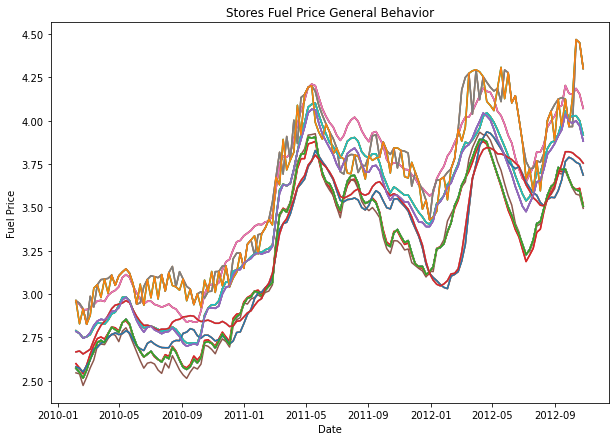

In [102]:
ys = []
x = data['Date'][data['Store']==1]
for i in stores:
  ys.append(data['Fuel_Price'][data['Store']==i])

plt.figure(figsize=(10,7))
plt.plot(x, ys[0])
plt.plot(x, ys[1])
plt.plot(x, ys[2])
plt.plot(x, ys[3])
plt.plot(x, ys[4])
plt.plot(x, ys[5])
plt.plot(x, ys[6])
plt.plot(x, ys[7])
plt.plot(x, ys[8])
plt.plot(x, ys[9])
plt.plot(x, ys[10])
plt.plot(x, ys[11])
plt.plot(x, ys[12])
plt.plot(x, ys[13])
plt.plot(x, ys[14])
plt.plot(x, ys[15])
plt.plot(x, ys[16])
plt.plot(x, ys[17])
plt.plot(x, ys[18])
plt.plot(x, ys[19])
plt.plot(x, ys[20])
plt.plot(x, ys[21])
plt.plot(x, ys[22])
plt.plot(x, ys[23])
plt.plot(x, ys[24])
plt.plot(x, ys[25])
plt.plot(x, ys[26])
plt.plot(x, ys[27])
plt.plot(x, ys[28])
plt.plot(x, ys[29])
plt.plot(x, ys[30])
plt.plot(x, ys[31])
plt.plot(x, ys[32])
plt.plot(x, ys[33])
plt.plot(x, ys[34])
plt.plot(x, ys[35])
plt.plot(x, ys[36])
plt.plot(x, ys[37])
plt.plot(x, ys[38])
plt.plot(x, ys[39])
plt.plot(x, ys[40])
plt.plot(x, ys[41])
plt.plot(x, ys[42])
plt.plot(x, ys[43])
plt.plot(x, ys[44])
plt.ylabel('Fuel Price')
plt.xlabel('Date')
plt.title('Stores Fuel Price General Behavior')

In [103]:
x = data['MarkDown1'][(pd.notna(data['MarkDown1'])) & (data['Store']==1)]

for i in stores:
  mk1 = data['MarkDown1'][(pd.notna(data['MarkDown1'])) & (data['Store']==i)]
  mn = np.median(mk1)
  data['MarkDown1'][(pd.isna(data['MarkDown1'])) & (data['Store']==i)] = mn

  mk2 = data['MarkDown2'][(pd.notna(data['MarkDown2'])) & (data['Store']==i)]
  mn = np.median(mk2)
  data['MarkDown2'][(pd.isna(data['MarkDown2'])) & (data['Store']==i)] = mn

  mk3 = data['MarkDown3'][(pd.notna(data['MarkDown3'])) & (data['Store']==i)]
  mn = np.median(mk3)
  data['MarkDown3'][(pd.isna(data['MarkDown3'])) & (data['Store']==i)] = mn

  mk4 = data['MarkDown4'][(pd.notna(data['MarkDown4'])) & (data['Store']==i)]
  mn = np.median(mk4)
  data['MarkDown4'][(pd.isna(data['MarkDown4'])) & (data['Store']==i)] = mn

  mk5 = data['MarkDown5'][(pd.notna(data['MarkDown5'])) & (data['Store']==i)]
  mn = np.median(mk5)
  data['MarkDown5'][(pd.isna(data['MarkDown5'])) & (data['Store']==i)] = mn

  cpi = data['CPI'][(pd.notna(data['CPI'])) & (data['Store']==i)]
  mn = np.median(cpi)
  data['CPI'][(pd.isna(data['CPI'])) & (data['Store']==i)] = mn

  unem = data['Unemployment'][(pd.notna(data['Unemployment'])) & (data['Store']==i)]
  mn = np.median(unem)
  data['Unemployment'][(pd.isna(data['Unemployment'])) & (data['Store']==i)] = mn

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_laun

,Date,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,2010-02-05,1,3184,1643690.90,42.31,2.572,6154.14,144.87,25.965,1822.55,4325.19,211.096358,8.106,0
1,2010-02-12,1,3137,1641957.44,38.51,2.548,6154.14,144.87,25.965,1822.55,4325.19,211.242170,8.106,1
2,2010-02-19,1,3184,1611968.17,39.93,2.514,6154.14,144.87,25.965,1822.55,4325.19,211.289143,8.106,0
3,2010-02-26,1,3137,1409727.59,46.63,2.561,6154.14,144.87,25.965,1822.55,4325.19,211.319643,8.106,0
4,2010-03-05,1,3215,1554806.68,46.50,2.625,6154.14,144.87,25.965,1822.55,4325.19,211.350143,8.106,0


Text(0.5, 1.0, 'Stores CPI General Behavior')

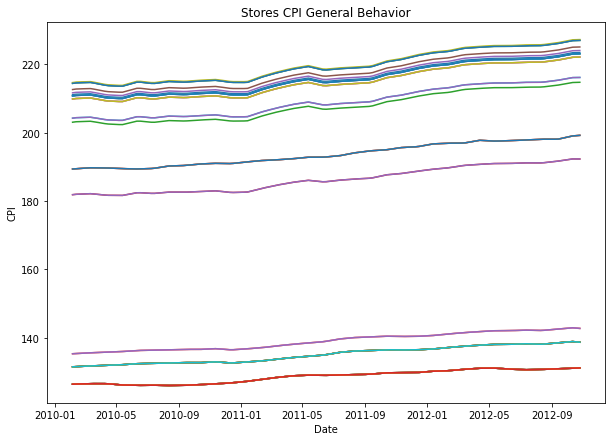

In [104]:
ys = []
x = data['Date'][data['Store']==1]
for i in stores:
  ys.append(data['CPI'][data['Store']==i])

plt.figure(figsize=(10,7))
plt.plot(x, ys[0])
plt.plot(x, ys[1])
plt.plot(x, ys[2])
plt.plot(x, ys[3])
plt.plot(x, ys[4])
plt.plot(x, ys[5])
plt.plot(x, ys[6])
plt.plot(x, ys[7])
plt.plot(x, ys[8])
plt.plot(x, ys[9])
plt.plot(x, ys[10])
plt.plot(x, ys[11])
plt.plot(x, ys[12])
plt.plot(x, ys[13])
plt.plot(x, ys[14])
plt.plot(x, ys[15])
plt.plot(x, ys[16])
plt.plot(x, ys[17])
plt.plot(x, ys[18])
plt.plot(x, ys[19])
plt.plot(x, ys[20])
plt.plot(x, ys[21])
plt.plot(x, ys[22])
plt.plot(x, ys[23])
plt.plot(x, ys[24])
plt.plot(x, ys[25])
plt.plot(x, ys[26])
plt.plot(x, ys[27])
plt.plot(x, ys[28])
plt.plot(x, ys[29])
plt.plot(x, ys[30])
plt.plot(x, ys[31])
plt.plot(x, ys[32])
plt.plot(x, ys[33])
plt.plot(x, ys[34])
plt.plot(x, ys[35])
plt.plot(x, ys[36])
plt.plot(x, ys[37])
plt.plot(x, ys[38])
plt.plot(x, ys[39])
plt.plot(x, ys[40])
plt.plot(x, ys[41])
plt.plot(x, ys[42])
plt.plot(x, ys[43])
plt.plot(x, ys[44])
plt.ylabel('CPI')
plt.xlabel('Date')
plt.title('Stores CPI General Behavior')

Text(0.5, 1.0, 'Stores Weekly Sales')

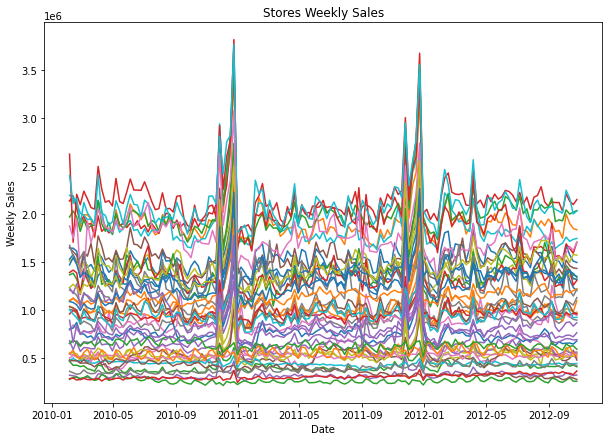

In [105]:
ys = []
x = data['Date'][data['Store']==1]
for i in stores:
  ys.append(data['Weekly_Sales'][data['Store']==i])

plt.figure(figsize=(10,7))
plt.plot(x, ys[0])
plt.plot(x, ys[1])
plt.plot(x, ys[2])
plt.plot(x, ys[3])
plt.plot(x, ys[4])
plt.plot(x, ys[5])
plt.plot(x, ys[6])
plt.plot(x, ys[7])
plt.plot(x, ys[8])
plt.plot(x, ys[9])
plt.plot(x, ys[10])
plt.plot(x, ys[11])
plt.plot(x, ys[12])
plt.plot(x, ys[13])
plt.plot(x, ys[14])
plt.plot(x, ys[15])
plt.plot(x, ys[16])
plt.plot(x, ys[17])
plt.plot(x, ys[18])
plt.plot(x, ys[19])
plt.plot(x, ys[20])
plt.plot(x, ys[21])
plt.plot(x, ys[22])
plt.plot(x, ys[23])
plt.plot(x, ys[24])
plt.plot(x, ys[25])
plt.plot(x, ys[26])
plt.plot(x, ys[27])
plt.plot(x, ys[28])
plt.plot(x, ys[29])
plt.plot(x, ys[30])
plt.plot(x, ys[31])
plt.plot(x, ys[32])
plt.plot(x, ys[33])
plt.plot(x, ys[34])
plt.plot(x, ys[35])
plt.plot(x, ys[36])
plt.plot(x, ys[37])
plt.plot(x, ys[38])
plt.plot(x, ys[39])
plt.plot(x, ys[40])
plt.plot(x, ys[41])
plt.plot(x, ys[42])
plt.plot(x, ys[43])
plt.plot(x, ys[44])
plt.ylabel('Weekly Sales')
plt.xlabel('Date')
plt.title('Stores Weekly Sales')

Substitute the NaN values of Markdown and CPI by the median value per store

##K-Means classification

Implement elbow method

In [106]:
def getWCSS(model,X,y_hat):
  wcss = 0

  for i in range(len(X)):
    dist2 = distance([X[i]], model.means[[y_hat[i]]])[0][0] ** 2
    wcss += dist2
  
  return wcss

In [107]:
X = data.loc[:][data['Weekly_Sales'].notna()]
X.drop('Date', inplace = True, axis = 1)
X = X.to_numpy().astype(float)

wcss = []
models = []
y_hats = []

for i in stores:
  print(f"Checking {i} of {stores[-1]}")
  model = K_Means(k=i)
  y_hat = model.fit(X)
  y_hats.append(y_hat)
  models.append(model)
  wcss.append(getWCSS(model,X,y_hat))

Checking 1 of 45
Checking 2 of 45
Checking 3 of 45
Checking 4 of 45
Checking 5 of 45
Checking 6 of 45
Checking 7 of 45
Checking 8 of 45
Checking 9 of 45
Checking 10 of 45
Checking 11 of 45
Checking 12 of 45
Checking 13 of 45
Checking 14 of 45
Checking 15 of 45
Checking 16 of 45
Checking 17 of 45
Checking 18 of 45
Checking 19 of 45
Checking 20 of 45
Checking 21 of 45
Checking 22 of 45
Checking 23 of 45
Checking 24 of 45
Checking 25 of 45
Checking 26 of 45
Checking 27 of 45
Checking 28 of 45
Checking 29 of 45
Checking 30 of 45
Checking 31 of 45
Checking 32 of 45
Checking 33 of 45
Checking 34 of 45
Checking 35 of 45
Checking 36 of 45
Checking 37 of 45
Checking 38 of 45
Checking 39 of 45
Checking 40 of 45
Checking 41 of 45
Checking 42 of 45
Checking 43 of 45
Checking 44 of 45
Checking 45 of 45


In [108]:
#Run after plotting
best = models[4]
y_hat = y_hats[4]

Text(0.5, 1.0, 'WCSS Comparison')

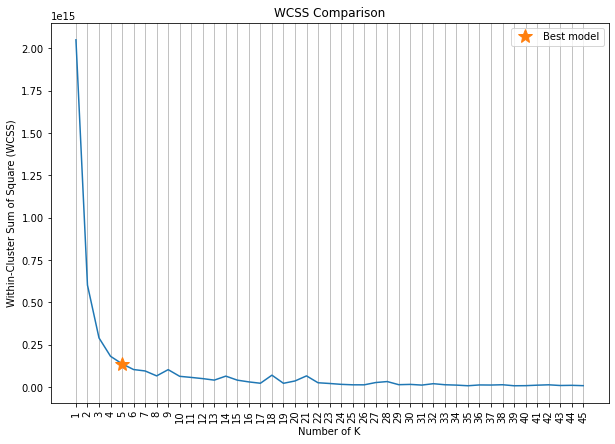

In [109]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(1,len(wcss)+1), wcss)
plt.plot(5,wcss[4], '*', markersize=15, label='Best model')
plt.legend()
plt.grid(axis='x', color='0.7')
plt.ylabel('Within-Cluster Sum of Square (WCSS)')
plt.xlabel('Number of K')
plt.xticks(np.arange(1,len(wcss)+1), rotation=90)
plt.title('WCSS Comparison')

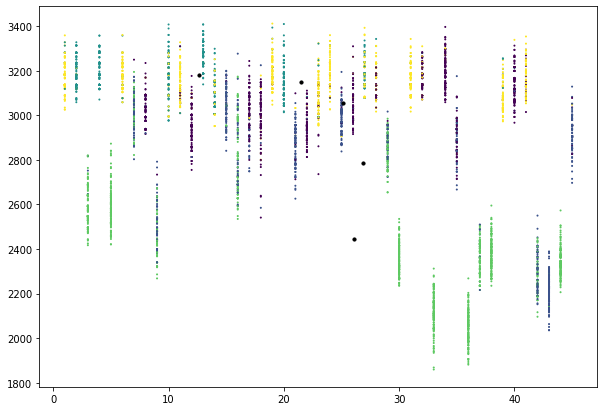

In [110]:
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],s=1,c=y_hat)
plt.scatter(best.means[:,0],best.means[:,1], c='k', s=10)

In [111]:
clusters = []
for i in range(len(data)):
  if i < len(y_hat):
    clusters.append(y_hat[i])
  else:
    clusters.append(np.NaN)

data['clusters'] = clusters
data

,Date,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,clusters
0,2010-02-05,1,3184,1643690.90,42.31,2.572,6154.14,144.87,25.965,1822.55,4325.19,211.096358,8.106,0,4
1,2010-02-12,1,3137,1641957.44,38.51,2.548,6154.14,144.87,25.965,1822.55,4325.19,211.242170,8.106,1,4
2,2010-02-19,1,3184,1611968.17,39.93,2.514,6154.14,144.87,25.965,1822.55,4325.19,211.289143,8.106,0,4
3,2010-02-26,1,3137,1409727.59,46.63,2.561,6154.14,144.87,25.965,1822.55,4325.19,211.319643,8.106,0,4
4,2010-03-05,1,3215,1554806.68,46.50,2.625,6154.14,144.87,25.965,1822.55,4325.19,211.350143,8.106,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,45,2853,713173.95,64.88,3.997,4556.61,20.64,1.500,1601.01,3288.25,192.013558,8.684,0,1
6431,2012-10-05,45,2952,733455.07,64.89,3.985,5046.74,187.59,18.820,2253.43,2340.01,192.170412,8.667,0,1
6432,2012-10-12,45,2853,734464.36,54.47,4.000,1956.28,187.59,7.890,599.32,3990.54,192.327265,8.667,0,1
6433,2012-10-19,45,2853,718125.53,56.47,3.969,2004.02,187.59,3.180,437.73,1537.49,192.330854,8.667,0,1


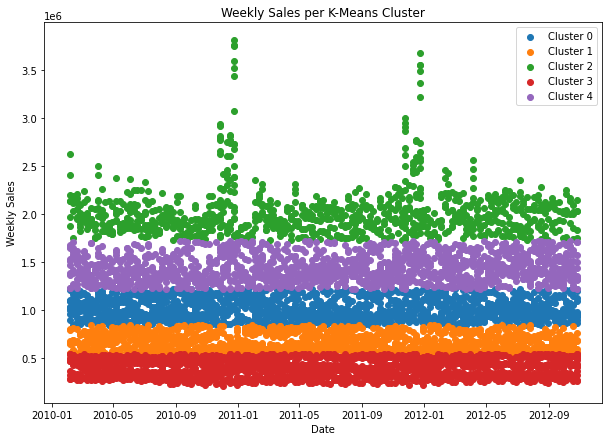

In [112]:
plt.figure(figsize=(10,7))
for i in range(5):
  plt.scatter(data['Date'][data['clusters']==i], data['Weekly_Sales'][data['clusters']==i], label=f"Cluster {i}")
plt.legend()
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.title("Weekly Sales per K-Means Cluster")
plt.show()

Get min, max, mean values of every feature for every class

In [113]:
cluster_params = dict()

for k in range(5):
  parameters = dict()
  parameters['minTemp'] = min(data['Temperature'][data['clusters']==k])
  parameters['maxTemp'] = max(data['Temperature'][data['clusters']==k])
  parameters['minFuel'] = min(data['Fuel_Price'][data['clusters']==k])
  parameters['maxFuel'] = max(data['Fuel_Price'][data['clusters']==k])
  parameters['minMk1'] = min(data['MarkDown1'][data['clusters']==k])
  parameters['maxMk1'] = max(data['MarkDown1'][data['clusters']==k])
  parameters['minMk2'] = min(data['MarkDown2'][data['clusters']==k])
  parameters['maxMk2'] = max(data['MarkDown2'][data['clusters']==k])
  parameters['minMk3'] = min(data['MarkDown3'][data['clusters']==k])
  parameters['maxMk3'] = max(data['MarkDown3'][data['clusters']==k])
  parameters['minMk4'] = min(data['MarkDown4'][data['clusters']==k])
  parameters['maxMk4'] = max(data['MarkDown4'][data['clusters']==k])
  parameters['minMk5'] = min(data['MarkDown5'][data['clusters']==k])
  parameters['maxMk5'] = max(data['MarkDown5'][data['clusters']==k])
  parameters['minCpi'] = min(data['CPI'][data['clusters']==k])
  parameters['maxCpi'] = max(data['CPI'][data['clusters']==k])
  parameters['minUnem'] = min(data['Unemployment'][data['clusters']==k])
  parameters['maxUnem'] = max(data['Unemployment'][data['clusters']==k])
  parameters['minSales'] = min(data['Weekly_Sales'][data['clusters']==k])
  parameters['maxSales'] = max(data['Weekly_Sales'][data['clusters']==k])

  cluster_params[f"Class {k}"] = parameters

print(cluster_params)

{'Class 0': {'minTemp': 6.23, 'maxTemp': 99.22, 'minFuel': 2.514, 'maxFuel': 4.468, 'minMk1': 35.94, 'maxMk1': 88646.76, 'minMk2': -7.6, 'maxMk2': 58804.91, 'minMk3': 0.06, 'maxMk3': 67073.91, 'minMk4': 3.0, 'maxMk4': 57815.43, 'minMk5': 171.76, 'maxMk5': 58068.14, 'minCpi': 126.064, 'maxCpi': 227.0369359, 'minUnem': 4.125, 'maxUnem': 14.313, 'minSales': 841129.26, 'maxSales': 1216876.52}, 'Class 1': {'minTemp': -2.06, 'maxTemp': 94.22, 'minFuel': 2.514, 'maxFuel': 4.468, 'minMk1': 2.12, 'maxMk1': 62567.6, 'minMk2': -7.01, 'maxMk2': 49913.53, 'minMk3': 0.0, 'maxMk3': 44061.13, 'minMk4': 2.8, 'maxMk4': 42448.94, 'minMk5': 135.16, 'maxMk5': 57029.78, 'minCpi': 126.064, 'maxCpi': 227.2328068, 'minUnem': 4.261, 'maxUnem': 14.021, 'minSales': 539337.87, 'maxSales': 839911.0}, 'Class 2': {'minTemp': 16.94, 'maxTemp': 95.36, 'minFuel': 2.514, 'maxFuel': 4.449, 'minMk1': 70.24, 'maxMk1': 78124.5, 'minMk2': -10.5, 'maxMk2': 104519.54, 'minMk3': 0.02, 'maxMk3': 141630.61, 'minMk4': 2.0, 'maxMk4'

Normalize the data with the min/max method of every class

In [114]:
for k in range(5):
  data['Temperature'][data['clusters']==k] = (data['Temperature'][data['clusters']==k]-data['Temperature'][data['clusters']==k].min()) / (data['Temperature'][data['clusters']==k].max()-data['Temperature'][data['clusters']==k].min())
  data['Fuel_Price'][data['clusters']==k] = (data['Fuel_Price'][data['clusters']==k]-data['Fuel_Price'][data['clusters']==k].min()) / (data['Fuel_Price'][data['clusters']==k].max()-data['Fuel_Price'][data['clusters']==k].min())
  data['MarkDown1'][data['clusters']==k] = (data['MarkDown1'][data['clusters']==k]-data['MarkDown1'][data['clusters']==k].min()) / (data['MarkDown1'][data['clusters']==k].max()-data['MarkDown1'][data['clusters']==k].min())
  data['MarkDown2'][data['clusters']==k] = (data['MarkDown2'][data['clusters']==k]-data['MarkDown2'][data['clusters']==k].min()) / (data['MarkDown2'][data['clusters']==k].max()-data['MarkDown2'][data['clusters']==k].min())
  data['MarkDown3'][data['clusters']==k] = (data['MarkDown3'][data['clusters']==k]-data['MarkDown3'][data['clusters']==k].min()) / (data['MarkDown3'][data['clusters']==k].max()-data['MarkDown3'][data['clusters']==k].min())
  data['MarkDown4'][data['clusters']==k] = (data['MarkDown4'][data['clusters']==k]-data['MarkDown4'][data['clusters']==k].min()) / (data['MarkDown4'][data['clusters']==k].max()-data['MarkDown4'][data['clusters']==k].min())
  data['MarkDown5'][data['clusters']==k] = (data['MarkDown5'][data['clusters']==k]-data['MarkDown5'][data['clusters']==k].min()) / (data['MarkDown5'][data['clusters']==k].max()-data['MarkDown5'][data['clusters']==k].min())
  data['CPI'][data['clusters']==k] = (data['CPI'][data['clusters']==k]-data['CPI'][data['clusters']==k].min()) / (data['CPI'][data['clusters']==k].max()-data['CPI'][data['clusters']==k].min())
  data['Unemployment'][data['clusters']==k] = (data['Unemployment'][data['clusters']==k]-data['Unemployment'][data['clusters']==k].min()) / (data['Unemployment'][data['clusters']==k].max()-data['Unemployment'][data['clusters']==k].min())
  data['Weekly_Sales'][data['clusters']==k] = (data['Weekly_Sales'][data['clusters']==k]-data['Weekly_Sales'][data['clusters']==k].min()) / (data['Weekly_Sales'][data['clusters']==k].max()-data['Weekly_Sales'][data['clusters']==k].min())

data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

,Date,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,clusters
0,2010-02-05,1,3184,0.846703,0.330282,0.029683,0.094195,0.004939,0.000766,0.026982,0.038344,0.842698,0.390754,0,4
1,2010-02-12,1,3137,0.843261,0.283901,0.017400,0.094195,0.004939,0.000766,0.026982,0.038344,0.844144,0.390754,1,4
2,2010-02-19,1,3184,0.783724,0.301233,0.000000,0.094195,0.004939,0.000766,0.026982,0.038344,0.844609,0.390754,0,4
3,2010-02-26,1,3137,0.382221,0.383010,0.024053,0.094195,0.004939,0.000766,0.026982,0.038344,0.844911,0.390754,0,4
4,2010-03-05,1,3215,0.670243,0.381423,0.056807,0.094195,0.004939,0.000766,0.026982,0.038344,0.845214,0.390754,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,45,2853,0.578349,0.695264,0.758956,0.072796,0.000554,0.000034,0.037653,0.055420,0.651876,0.453176,0,1
6431,2012-10-05,45,2952,0.645824,0.695368,0.752815,0.080629,0.003898,0.000427,0.053023,0.038753,0.653427,0.451434,0,1
6432,2012-10-12,45,2853,0.649181,0.587142,0.760491,0.031234,0.003898,0.000179,0.014054,0.067764,0.654977,0.451434,0,1
6433,2012-10-19,45,2853,0.594822,0.607914,0.744626,0.031997,0.003898,0.000072,0.010247,0.024648,0.655013,0.451434,0,1


In [115]:
data.drop('Dept', inplace = True, axis = 1)
data.drop('IsHoliday', inplace=True, axis=1)
data.drop('Store', inplace=True, axis=1)
data

,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,clusters
0,2010-02-05,0.846703,0.330282,0.029683,0.094195,0.004939,0.000766,0.026982,0.038344,0.842698,0.390754,4
1,2010-02-12,0.843261,0.283901,0.017400,0.094195,0.004939,0.000766,0.026982,0.038344,0.844144,0.390754,4
2,2010-02-19,0.783724,0.301233,0.000000,0.094195,0.004939,0.000766,0.026982,0.038344,0.844609,0.390754,4
3,2010-02-26,0.382221,0.383010,0.024053,0.094195,0.004939,0.000766,0.026982,0.038344,0.844911,0.390754,4
4,2010-03-05,0.670243,0.381423,0.056807,0.094195,0.004939,0.000766,0.026982,0.038344,0.845214,0.390754,4
...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,0.578349,0.695264,0.758956,0.072796,0.000554,0.000034,0.037653,0.055420,0.651876,0.453176,1
6431,2012-10-05,0.645824,0.695368,0.752815,0.080629,0.003898,0.000427,0.053023,0.038753,0.653427,0.451434,1
6432,2012-10-12,0.649181,0.587142,0.760491,0.031234,0.003898,0.000179,0.014054,0.067764,0.654977,0.451434,1
6433,2012-10-19,0.594822,0.607914,0.744626,0.031997,0.003898,0.000072,0.010247,0.024648,0.655013,0.451434,1


##CPI prediction

Get the mean value of each class per date into a particular dataset

In [116]:
dates = np.unique(data['Date'])
datasets = dict()

for k in range(5):
  dataset = pd.DataFrame(columns=['Date','Weekly_Sales','Temperature','Fuel_Price','MarkDown1','MarkDown2',
                                  'MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment'])
  for date in dates:
    temp = data[(data['clusters']==k) & (data['Date']==date)].mean()
    dataset = dataset.append({'Date':date, 'Weekly_Sales':temp[0], 'Temperature':temp[1], 'Fuel_Price':temp[2], 'MarkDown1':temp[3],
                              'MarkDown2':temp[4], 'MarkDown3':temp[5], 'MarkDown4':temp[6], 'MarkDown5':temp[7], 'CPI':temp[8],
                              'Unemployment':temp[9]}, ignore_index=True)
    
  datasets[f'Cluster {k}'] = dataset

print(f"Saved {len(datasets)} dataframes")
print(datasets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


Saved 5 dataframes
{'Cluster 0':           Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0   2010-02-05      0.529171     0.234950    0.106858   0.070488   0.003797   
1   2010-02-12      0.543479     0.236233    0.097004   0.069542   0.003934   
2   2010-02-19      0.408600     0.294655    0.077324   0.070980   0.003564   
3   2010-02-26      0.439404     0.312192    0.096685   0.072300   0.004420   
4   2010-03-05      0.517109     0.349941    0.112948   0.070826   0.004064   
..         ...           ...          ...         ...        ...        ...   
138 2012-09-28      0.374047     0.622368    0.706551   0.044137   0.001041   
139 2012-10-05      0.479584     0.593429    0.703685   0.055167   0.003811   
140 2012-10-12      0.445087     0.519430    0.751791   0.018854   0.003629   
141 2012-10-19      0.434956     0.532627    0.741709   0.018759   0.003393   
142 2012-10-26      0.458710     0.556775    0.687587   0.059299   0.001547   

     MarkDown3  Ma

In [117]:
datasets['Cluster 3'] = datasets['Cluster 3'].dropna()
datasets['Cluster 3'].reset_index()
datasets['Cluster 3'].isna().sum()

Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

Get the parameter *d* for ARIMA

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from numpy.core.shape_base import block

In [119]:
from statsmodels.tsa.stattools import adfuller

In [120]:
def test_stationarity(df, ts):

  rolmean = df[ts].rolling(window=12, center=False).mean()
  rolstd = df[ts].rolling(window=12, center=False).std()

  orig = plt.plot(df[ts], color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')

  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation for %s' %(ts))
  plt.xticks(rotation=45)
  plt.show(block=False)
  plt.close

  print('Results:')
  dftest = adfuller(df[ts], autolag = 'AIC' )
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p=value','# Lasgs Used', 'Numer of Observations'])

  for key, value in dftest[4].items():
    dfoutput['Critical Value(%s)' %key] = value

  print(dfoutput)

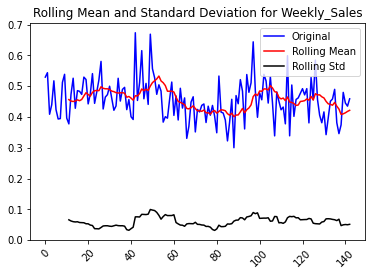

Results:
Test Statistic            -3.359487
p=value                    0.012420
# Lasgs Used               4.000000
Numer of Observations    138.000000
Critical Value(1%)        -3.478648
Critical Value(5%)        -2.882722
Critical Value(10%)       -2.578065
dtype: float64


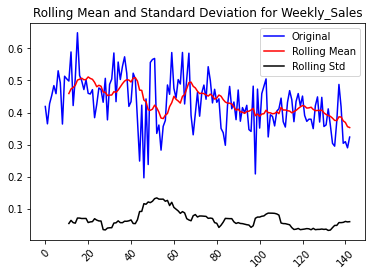

Results:
Test Statistic            -5.051653
p=value                    0.000018
# Lasgs Used               1.000000
Numer of Observations    141.000000
Critical Value(1%)        -3.477601
Critical Value(5%)        -2.882266
Critical Value(10%)       -2.577822
dtype: float64


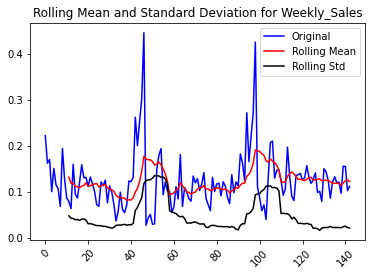

Results:
Test Statistic          -6.103321e+00
p=value                  9.717294e-08
# Lasgs Used             4.000000e+00
Numer of Observations    1.380000e+02
Critical Value(1%)      -3.478648e+00
Critical Value(5%)      -2.882722e+00
Critical Value(10%)     -2.578065e+00
dtype: float64


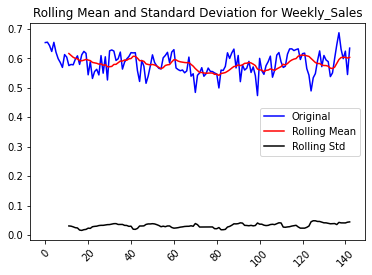

Results:
Test Statistic            -5.335576
p=value                    0.000005
# Lasgs Used               1.000000
Numer of Observations    141.000000
Critical Value(1%)        -3.477601
Critical Value(5%)        -2.882266
Critical Value(10%)       -2.577822
dtype: float64


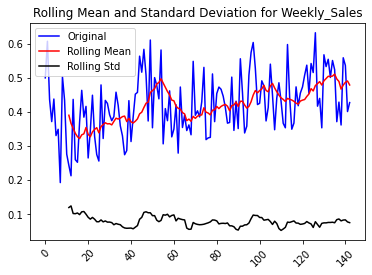

Results:
Test Statistic            -3.309570
p=value                    0.014456
# Lasgs Used               5.000000
Numer of Observations    137.000000
Critical Value(1%)        -3.479007
Critical Value(5%)        -2.882878
Critical Value(10%)       -2.578149
dtype: float64


In [121]:
test_stationarity(datasets['Cluster 0'], 'Weekly_Sales')
test_stationarity(datasets['Cluster 1'], 'Weekly_Sales')
test_stationarity(datasets['Cluster 2'], 'Weekly_Sales')
test_stationarity(datasets['Cluster 3'], 'Weekly_Sales')
test_stationarity(datasets['Cluster 4'], 'Weekly_Sales')

Make stationary the clusters that are not

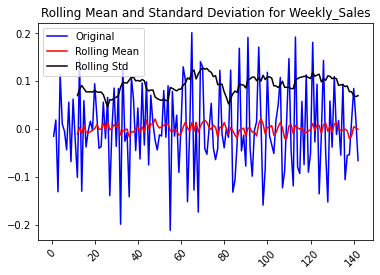

Results:
Test Statistic          -7.803145e+00
p=value                  7.400996e-12
# Lasgs Used             7.000000e+00
Numer of Observations    1.340000e+02
Critical Value(1%)      -3.480119e+00
Critical Value(5%)      -2.883362e+00
Critical Value(10%)     -2.578407e+00
dtype: float64


In [65]:
# datasets['Cluster 4'] = datasets['Cluster 4'].diff().dropna()
# test_stationarity(datasets['Cluster 4'], 'Weekly_Sales')

In [ ]:
d = [1, 0, 0, 0, 0]

Get the parameter *p* for ARIMA

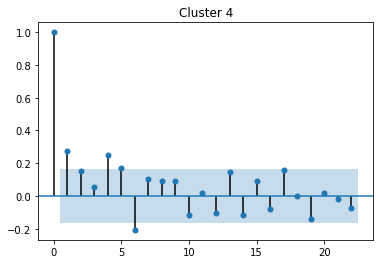

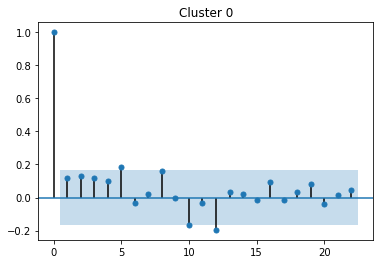

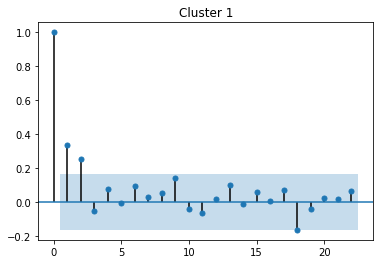

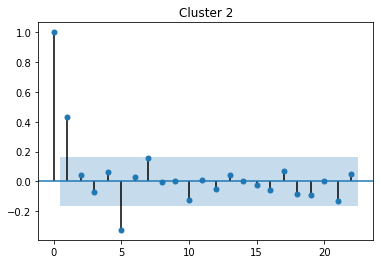

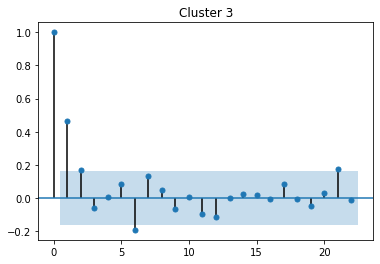

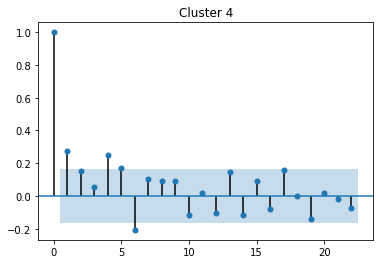

In [122]:
plot_pacf(datasets['Cluster 0']['Weekly_Sales'], title='Cluster 0')
plot_pacf(datasets['Cluster 1']['Weekly_Sales'], title='Cluster 1')
plot_pacf(datasets['Cluster 2']['Weekly_Sales'], title='Cluster 2')
plot_pacf(datasets['Cluster 3']['Weekly_Sales'], title='Cluster 3')
plot_pacf(datasets['Cluster 4']['Weekly_Sales'], title='Cluster 4')

Get the time-series

In [180]:
from fbprophet import Prophet
import datetime

In [368]:
model_data = data.filter(['Date','Weekly_Sales', 'clusters']).copy()

In [369]:
model_data

,Date,Weekly_Sales,clusters
0,2010-02-05,0.846703,4
1,2010-02-12,0.843261,4
2,2010-02-19,0.783724,4
3,2010-02-26,0.382221,4
4,2010-03-05,0.670243,4
...,...,...,...
6430,2012-09-28,0.578349,1
6431,2012-10-05,0.645824,1
6432,2012-10-12,0.649181,1
6433,2012-10-19,0.594822,1


In [370]:
model_data = model_data.loc[model_data['clusters'] == 0]

In [371]:
model_data

,Date,Weekly_Sales,clusters
904,2010-12-24,0.542906,0
952,2011-11-25,0.287285,0
956,2011-12-23,0.581737,0
1001,2010-02-05,0.433823,0
1002,2010-02-12,0.408977,0
...,...,...,...
6389,2011-12-16,0.632809,0
6391,2011-12-30,0.075248,0
6398,2012-02-17,0.047171,0
6405,2012-04-06,0.155291,0


In [372]:
model_data.drop('clusters', axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [373]:
model_data.columns = ['ds', 'y']

In [374]:
model_data.head()

,ds,y
904,2010-12-24,0.542906
952,2011-11-25,0.287285
956,2011-12-23,0.581737
1001,2010-02-05,0.433823
1002,2010-02-12,0.408977


In [400]:
model = Prophet(changepoint_prior_scale=1)
model.fit(model_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [401]:
future_data = model.make_future_dataframe(periods=90)

In [402]:
forecasts = model.predict(future_data)

Text(0.5, 1.0, '90 day Prediction')

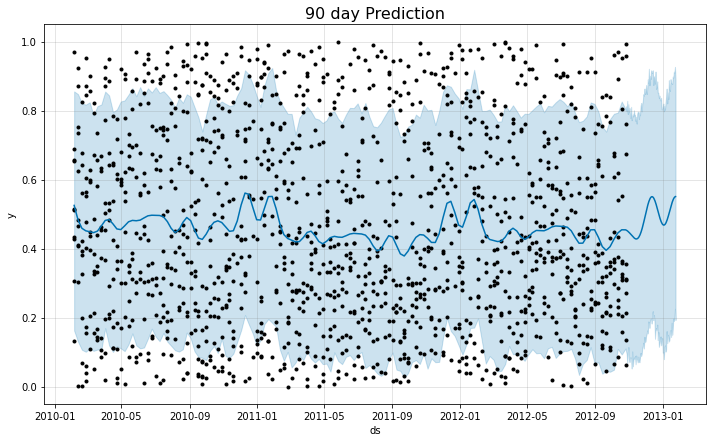

In [403]:
model.plot(forecasts)
plt.title('90 day Prediction', size=16)

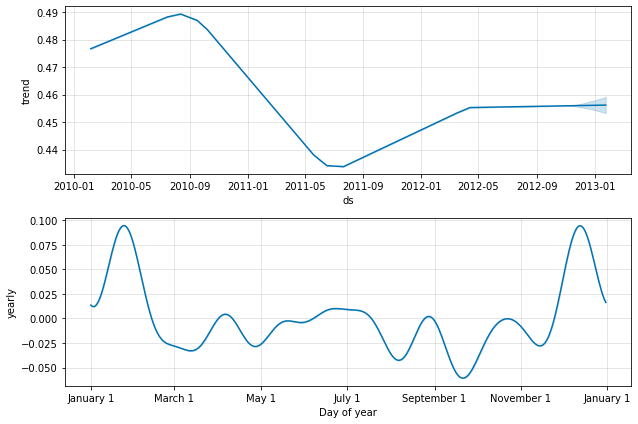

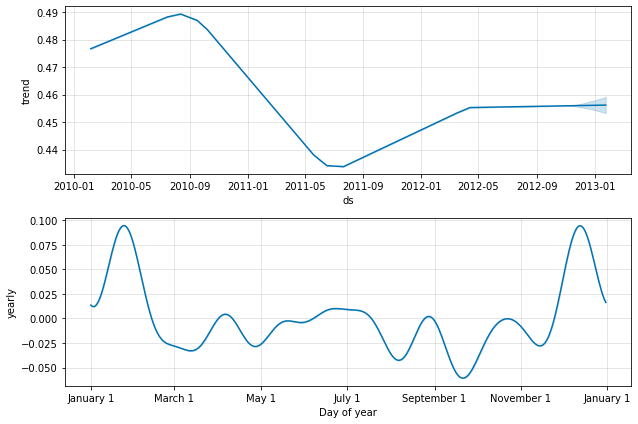

In [405]:
model.plot_components(forecasts)

In [278]:
forecasts

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,0.492840,0.166202,0.889764,0.492840,0.492840,0.038801,0.038801,0.038801,0.038801,0.038801,0.038801,0.0,0.0,0.0,0.531642
1,2010-02-12,0.488825,0.128433,0.830480,0.488825,0.488825,-0.003133,-0.003133,-0.003133,-0.003133,-0.003133,-0.003133,0.0,0.0,0.0,0.485691
2,2010-02-19,0.484809,0.095505,0.830445,0.484809,0.484809,-0.026259,-0.026259,-0.026259,-0.026259,-0.026259,-0.026259,0.0,0.0,0.0,0.458550
3,2010-02-26,0.480793,0.092954,0.794280,0.480793,0.480793,-0.031783,-0.031783,-0.031783,-0.031783,-0.031783,-0.031783,0.0,0.0,0.0,0.449011
4,2010-03-05,0.476778,0.104156,0.772587,0.476778,0.476778,-0.032984,-0.032984,-0.032984,-0.032984,-0.032984,-0.032984,0.0,0.0,0.0,0.443794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2013-01-20,0.449923,0.135213,0.873667,0.420176,0.478673,0.078041,0.078041,0.078041,0.078041,0.078041,0.078041,0.0,0.0,0.0,0.527964
229,2013-01-21,0.449894,0.151550,0.874709,0.419303,0.479864,0.081152,0.081152,0.081152,0.081152,0.081152,0.081152,0.0,0.0,0.0,0.531046
230,2013-01-22,0.449866,0.175170,0.862489,0.418810,0.480568,0.083488,0.083488,0.083488,0.083488,0.083488,0.083488,0.0,0.0,0.0,0.533353
231,2013-01-23,0.449837,0.154841,0.902937,0.418210,0.481079,0.084998,0.084998,0.084998,0.084998,0.084998,0.084998,0.0,0.0,0.0,0.534835


In [279]:
forecasts[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,0.531642,0.166202,0.889764
1,2010-02-12,0.485691,0.128433,0.830480
2,2010-02-19,0.458550,0.095505,0.830445
3,2010-02-26,0.449011,0.092954,0.794280
4,2010-03-05,0.443794,0.104156,0.772587


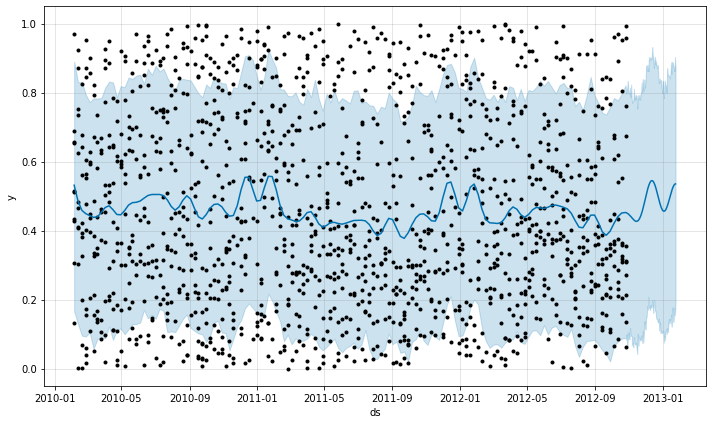

In [280]:
fig = model.plot(forecasts)

In [281]:
a = (cluster_params['Class 0']['maxSales'] - cluster_params['Class 0']['maxSales']) + cluster_params['Class 0']['minSales']
a

841129.26

In [282]:
forecasts['yhat'] = (forecasts['yhat']*a)

In [283]:
forecasts[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,447179.451395,0.166202,0.889764
1,2010-02-12,408529.063351,0.128433,0.830480
2,2010-02-19,385699.599354,0.095505,0.830445
3,2010-02-26,377676.101359,0.092954,0.794280
4,2010-03-05,373287.923616,0.104156,0.772587
...,...,...,...,...
228,2013-01-20,444085.885593,0.135213,0.873667
229,2013-01-21,446678.660803,0.151550,0.874709
230,2013-01-22,448618.949889,0.175170,0.862489
231,2013-01-23,449865.252997,0.154841,0.902937


Text(0.5, 0, 'Date')

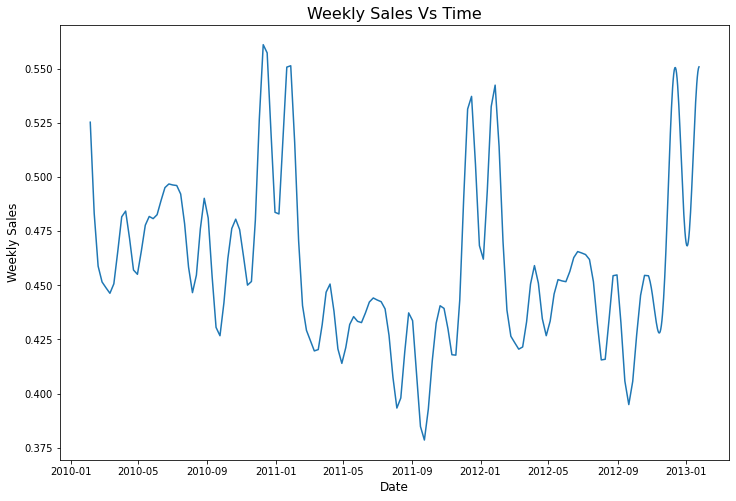

In [411]:
plt.figure(figsize=(12,8))
plt.plot(forecasts['ds'], forecasts['yhat'])
plt.title('Weekly Sales Vs Time', size=16)
plt.ylabel('Weekly Sales',size=12)
plt.xlabel('Date', size=12)

In [299]:
model_data = data.filter(['Date','Weekly_Sales', 'clusters']).copy()
model_data.columns = ['ds', 'y', 'clusters']
a = (cluster_params['Class 0']['maxSales'] - cluster_params['Class 0']['maxSales']) + cluster_params['Class 0']['minSales']

In [296]:
# for f in range(5):
#   model_data = model_data.loc[model_data['clusters']==f]
#   temp = model_data.drop('clusters', axis = 1)
#   model = Prophet(changepoint_prior_scale=12)
#   model.fit(temp)
#   future_data = model.make_future_dataframe(periods=90)
#   forecasts = model.predict(future_data)
#   model.plot(forecasts)
#   model.plot_components(forecasts)
#   model.plot_components(forecasts)
#   forecasts['yhat'] = (forecasts['yhat']*a)
#   forecasts[['ds','yhat','yhat_lower','yhat_upper']]
#   plt.plot(forecasts['ds'], forecasts['yhat'])

In [327]:
model_data = model_data.reset_index('ds')

In [328]:
model_data.dtypes

ds          datetime64[ns]
y                  float64
clusters             int64
dtype: object

In [339]:
days = [5, 30, 90]
for day in days:
  for k in range(5):
    temp = model_data.loc[model_data['clusters'] == k]
    temp = model_data.drop('clusters', axis = 1)
    model = Prophet(changepoint_prior_scale=12)
    print('Cluster ', k)
    print('Days', day)
    model.fit(temp)
    future_data = model.make_future_dataframe(periods=day)
    forecasts = model.predict(future_data)
    model.plot(forecasts)
    plt.show()
    model.plot_components(forecasts)
    plt.show()
    model.plot_components(forecasts)
    plt.show()
    forecasts['yhat'] = (forecasts['yhat']*a)
    plt.plot(forecasts['ds'], forecasts['yhat'])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [268]:
forecasts['yhat'].unique()

array([454687.7067553 , 412536.7273808 , 387912.5678914 , 378751.69874244,
       373088.3528111 , 366419.65967226, 366447.18536035, 377032.22798083,
       389404.15236331, 393493.39538364, 383860.29128818, 372608.67180425,
       372713.52238422, 384268.21072596, 398861.86670839, 405553.95976255,
       406702.45934631, 409601.86169642, 416212.01705089, 422597.0523268 ,
       424489.12465086, 423810.06961681, 423111.69692575, 419485.41004675,
       410023.35431889, 394951.36922547, 386443.55191396, 395148.4639087 ,
       409446.25276071, 420110.73522606, 413593.52704181, 393292.41678985,
       375452.43101119, 372915.12694848, 384476.99326418, 400345.64836853,
       402870.78934802, 399862.57288154, 389878.21642521, 371213.28152419,
       363479.32861016, 365421.37039891, 389244.92025836, 428676.03079568,
       457543.657098  , 463503.21562122, 438342.81889638, 413348.40745329,
       418727.64522063, 454293.38087377, 476775.16134282, 471228.69704164,
       436556.73464401, 3

In [241]:
model_data

,ds,y
904,2010-12-24,0.542906
952,2011-11-25,0.287285
956,2011-12-23,0.581737
1001,2010-02-05,0.433823
1002,2010-02-12,0.408977
...,...,...
6389,2011-12-16,0.632809
6391,2011-12-30,0.075248
6398,2012-02-17,0.047171
6405,2012-04-06,0.155291


##Working with the Test Set

Use the data to determine to which class the observation belongs to.

After that, use the corresponding trained model for predicting

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Enhance It/Training Projects/Time Series/test.csv")
test['Date'] = pd.to_datetime(test['Date'], dayfirst=False)
test

In [ ]:
test = test.groupby(['Store','Date','IsHoliday']).agg('sum')
test